In [1]:
import numpy as np
from scipy import sparse
from sklearn import svm
import pandas as pd
import pickle
from keras.layers import Dense
from keras.models import Sequential
import keras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

/home/andrewblance/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
inspire = pd.read_pickle('REFS')
inspire = inspire.reset_index(drop=True)
inspire.head()

,Text,Title-sing,Title-bi,Title-tri,Title-quad,Abs-sing,Abs-bi,Abs-tri,Abs-quad,core refs,non-core refs,Result
0,Mott Quantum Criticality in the Anisotropic 2D...,0,0,0,0,9,0,0,0,0.00000,0.50000,0
1,Balanced Reed-Solomon Codes We consider the pr...,0,0,0,0,11,1,0,0,0.00000,0.00000,0
2,Fermion Dipole Moment and Holography In the ba...,0,0,0,0,9,2,0,0,0.93617,0.00000,2
3,Quantization conditions and functional equatio...,0,0,0,0,9,1,0,0,0.92500,0.02500,2
4,"Resonances in the continuum, field induced non...",2,0,0,0,6,0,0,0,0.00000,0.04386,0


In [3]:
# tokenise text for later
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(inspire['Text'])
sequences = tokenizer.texts_to_sequences(inspire['Text'])
data = pad_sequences(sequences, maxlen=500)

In [55]:
# SPLIT DATA INTO TRAIN/ TEST
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

train = data[:training_samples]
val = data[training_samples:training_samples + validation_samples]
test = data[training_samples + validation_samples:]

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples].reset_index(drop=True)
inspire_test = inspire[training_samples + validation_samples:].reset_index(drop=True)

## net 

here, I want to make a neurel net, train it for the text, syphon of the auxiliary layer and put it into an SVM with the reference data

In [5]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

main_input = Input(shape=(500,), dtype='float', name='main_input')
x = Embedding(output_dim=100, input_dim=10000, input_length = 500)(main_input)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(100, activation='relu')(x)
auxiliary_output = Dense(32, activation='sigmoid', name='aux_output')(x)

main_output = Dense(3, activation='softmax', name='main_output')(x)

model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [6]:
history = model.fit({'main_input': train}, 
                    {'main_output': inspire_train['Result'], 'aux_output': inspire_train['Result']}, 
                    epochs=1, batch_size=32, 
                    validation_data=({'main_input':val},
                                     {'main_output': inspire_val['Result'],'aux_output': inspire_val['Result']}))

Train on 23264 samples, validate on 7754 samples
Epoch 1/1
23264/23264 [==============================] - 28s 1ms/step - loss: 0.8697 - main_output_loss: 0.4167 - aux_output_loss: 0.4530 - main_output_acc: 0.8555 - aux_output_acc: 0.8523 - val_loss: 0.5755 - val_main_output_loss: 0.2881 - val_aux_output_loss: 0.2874 - val_main_output_acc: 0.8995 - val_aux_output_acc: 0.8990


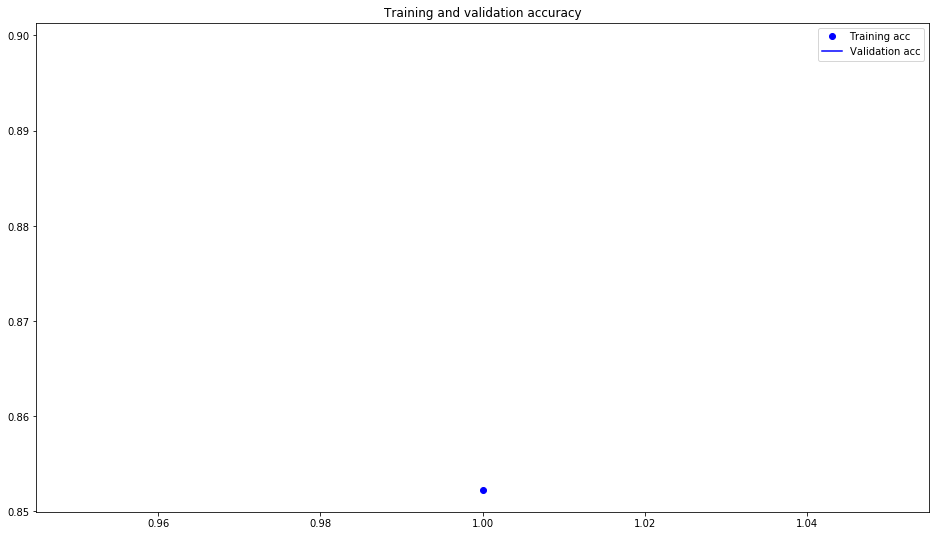

In [7]:
acc = history.history['aux_output_acc']
val_acc = history.history['val_aux_output_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Now, we can take the auxiliary data and play with it. Theres 16 columns, thats quite a lot, maybe do PCA with it?

In [8]:
# put training/ val through model
Ptrain = model.predict(train)
Pvec = model.predict(val)
# take just the aux stuff
T = Ptrain[1]
V = Pvec[1]
# lets try reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(.99999)
pca.fit(T)
pca.n_components_

In [12]:
# do the transform: 32 -> 3
Ptr = pca.transform(T)
Pv = pca.transform(V)

In [69]:
#check to see if its all good
svc = svm.SVC(decision_function_shape='ovo', kernel='linear', probability=True)
SVC = svc.fit(Ptr, inspire_train['Result'])

print SVC.score(Pv, inspire_val['Result'])

0.9003095176683003


build a new df

In [56]:
#put the 3 PC columns into original df's
PCA_ = ['PC1', 'PC2', 'PC3']
training = pd.DataFrame(Ptr, columns=PCA_)
inspire_train = pd.concat([inspire_train, training], axis = 1)

val = pd.DataFrame(Pv, columns=PCA_)
inspire_val   = pd.concat([inspire_val, val], axis = 1)

In [72]:
# quick check of quality
inputs = ['Title-sing', 'Title-bi', 'Title-tri', 'Title-quad', 'Abs-sing','Abs-bi', 'Abs-tri', 'Abs-quad','core refs', 'non-core refs', 'PC1', 'PC2', 'PC3']
svc = svm.SVC(decision_function_shape='ovo', kernel='linear', probability=True)
SVC = svc.fit(inspire_train[inputs], inspire_train['Result'])
print SVC.score(inspire_val[inputs], inspire_val['Result'])

0.9206860974980655


## SVM 

scores

In [61]:
svc = svm.SVC(decision_function_shape='ovo', kernel='linear', probability=True)
#svc = svm.SVC(C=1, kernel='linear')
keysPC = ['core refs', 'non-core refs']
SVC = svc.fit(inspire_train[keysPC], inspire_train['Result'])

In [62]:
dec = svc.decision_function(inspire_val[keysPC])
print dec

[[ 0.71  1.49  1.38]
 [ 1.44  1.61  1.09]
 [ 1.65  1.65  1.  ]
 ...
 [ 1.65  1.65  1.  ]
 [ 1.65  1.65  1.  ]
 [-1.18 -1.18 -0.24]]


In [64]:
print SVC.score(inspire_val[keysPC], inspire_val['Result'])

0.914753675522311


In [65]:
class_probabilities = svc.predict_proba(inspire_val[keysPC])
print class_probabilities[1]

[0.95 0.04 0.01]


In [66]:
X = inspire_train[keysPC]
y = inspire_train['Result']

#svc = svm.SVC(kernel='linear')
svc = svm.SVC(decision_function_shape='ovo')

C_s = np.logspace(-4, 2, 7)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.7, 1 )
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-4, 2, 7)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)

clf.fit(inspire_train[keysPC], inspire_train['Result']) 

print clf.best_score_ 
print clf.best_estimator_.C  

Confusion Matrix

0.914753675522311
Normalized confusion matrix
[[0.98 0.02 0.  ]
 [0.49 0.41 0.1 ]
 [0.07 0.03 0.9 ]]


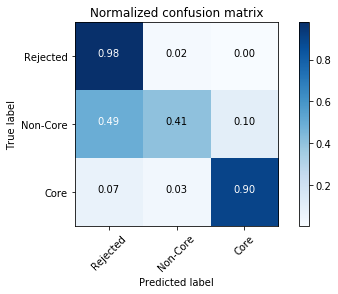

In [63]:
class_names = ["Rejected", "Non-Core", "Core"]

X_test = inspire_val[keysPC]
y_test = inspire_val['Result']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
# classifier = svm.SVC(decision_function_shape='ovo', C=clf.best_estimator_.C)

#classifier = svm.SVC(decision_function_shape='ovo', class_weight='balanced', C=1)
y_pred = SVC.predict(X_test)
print SVC.score(X_test, y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()